In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import project_path
from project_path import (
    module_path,
    configuration_dir, 
    data_dir, 
    report_dir,
    model_dir
)
from shorelineforecasting.utils.configs import GluonConfigs

In [2]:
tf = GluonConfigs.load_data()
tf = tf.set_index('transect_id')
tf = tf.dropna(thresh=33)
print(f"Transects included in dataset: {tf.shape[0]}; timesteps: {tf.shape[1]}")
tf.head()

Transects included in dataset: 37111; timesteps: 33


,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
transect_id,,,,,,,,,,,,,,,,,,,,,
BOX_051_151_15,677.32043,695.66370,713.29486,682.1743,688.23425,672.13007,700.43286,693.43460,699.38560,687.97950,...,700.6640,712.41740,708.45123,740.33240,680.42510,758.35150,754.49695,763.04297,743.29680,779.41570
BOX_051_151_18,768.93800,769.23883,762.44300,755.8622,761.79663,760.51710,763.30505,761.81360,769.22100,765.47060,...,763.1057,759.72600,766.23150,770.77130,798.26830,797.99615,803.90950,797.90780,798.18830,803.68256
BOX_051_151_21,711.41626,684.20540,695.49817,701.6695,705.29990,703.61470,707.69403,692.90360,704.68280,704.99945,...,825.8698,820.51720,820.68680,842.18097,850.45460,775.96700,883.04240,867.92426,877.37415,874.50244
BOX_051_151_30,795.81573,820.63700,799.72380,799.8664,823.56260,822.07300,823.56800,823.73300,824.58400,824.33360,...,823.7820,823.15674,823.65790,821.31860,818.85803,817.31220,822.92970,818.73350,822.18480,818.73480
BOX_051_151_32,242.70204,238.05159,229.93718,244.0620,247.68105,257.49900,302.69217,301.27722,301.12033,316.40414,...,301.1231,313.63553,313.09814,312.90347,306.18658,294.18326,297.23654,302.88650,323.85840,304.36823


In [3]:
sites = pd.read_csv("/media/storage/data/shorelines/sites-gluonts-prepared-37k.csv")
sites = sites.loc[sites['transect_id'].isin(tf.index)]
print(f"Transects included in dataset: {sites.shape[0]}; metadata columns: {sites.shape[1]}")
sites.head()

Transects included in dataset: 37111; metadata columns: 27


,transect_id,country_id,continent,country_name,changerate,changerate_unc,flag_sandy,no_shorelines,RMSE,Timespan,...,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,coastline_idint,geometry,dbscan_cluster,fcluster,optics_clusters
0,BOX_051_170_3,ARG,South America,Argentina,0.389332,0.344834,True,33.0,18.281954,32.0,...,-36.378387,-56.709120,-36.376892,-56.700333,-36.375397,7427,POINT (-56.70912170410156 -36.37689208984375),0,2455,0
1,BOX_051_170_4,ARG,South America,Argentina,0.501007,0.390176,True,33.0,20.685827,32.0,...,-36.374847,-56.710050,-36.373356,-56.701260,-36.371860,7427,POINT (-56.71004867553711 -36.37335586547852),0,2455,0
2,BOX_051_170_5,ARG,South America,Argentina,0.831012,0.331491,True,33.0,17.574545,32.0,...,-36.371933,-56.711193,-36.369860,-56.702587,-36.367786,7427,POINT (-56.7111930847168 -36.3698616027832),0,2455,0
3,BOX_051_170_6,ARG,South America,Argentina,1.471142,0.277497,True,33.0,14.711926,32.0,...,-36.368470,-56.712482,-36.366394,-56.703876,-36.364323,7427,POINT (-56.71248245239258 -36.36639404296875),0,2455,0
4,BOX_051_170_7,ARG,South America,Argentina,2.159336,0.288062,True,33.0,15.272047,32.0,...,-36.365000,-56.713768,-36.362930,-56.705162,-36.360855,7427,POINT (-56.71376800537109 -36.36293029785156),0,2455,0


In [4]:
metadata = {
    'num_series': len(tf),
    'num_steps': len(tf.columns),
    'prediction_length': 7,
    'freq': "AS",
    'start': [pd.Timestamp("01-01-1984", freq='AS') for _ in range(len(tf))],
    'item_id': tf.index.values,
    'epochs': 10,
    'save_model': False,
    'evaluate_model': True,
    'keep_forecasts': False,
}

In [5]:
from sklearn import preprocessing


transformations = {
    "standarize": preprocessing.StandardScaler(),
    "min-max-scale": preprocessing.MinMaxScaler()
}


def scale_df(df, method):
    x = df.values
    scaler = transformations[method]
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

tf_z = scale_df(tf.T, method='standarize').T

In [6]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName


def get_gluon_ds(df, sample=None):
    
    if sample is not None:
        df = df.sample(sample)

    train_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values[:, :-metadata['prediction_length']],
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])

    test_ds = ListDataset(
        [
         {
             FieldName.TARGET: target,
             FieldName.START: start,
             FieldName.ITEM_ID: item_id,
             FieldName.FEAT_STATIC_CAT: [fclust, dbclust],
             FieldName.FEAT_STATIC_REAL: [fsr]
          }

         for (target, start, item_id, fclust, dbclust, fsr) in zip(df.values,
                                            metadata['start'], 
                                            metadata['item_id'],
                                            sites['fcluster'].values,
                                            sites['dbscan_cluster'].values,
                                            sites['changerate_unc'].values)
        ], freq=metadata['freq'])
          
    return train_ds, test_ds

In [7]:
train_ds, test_ds = get_gluon_ds(tf_z, sample=1000)

In [9]:
import inspect
from pathlib import Path

from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

from shorelineforecasting.utils.configs import get_predictor_id


def get_cls_attributes(cls):
    attributes = inspect.getmembers(cls, lambda x: not(inspect.isroutine(x)))
    attributes = [a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]
    return dict(attributes)


def get_hyperparams(estimator, predictor_id):
    predictor = type(estimator).__name__
    estimator_attr = get_cls_attributes(estimator)
    trainer_attr = get_cls_attributes(estimator_attr['trainer'])
    attributes = {**estimator_attr, **trainer_attr}
    attributes.pop('trainer', None)
    attributes['predictor'] = predictor
    attributes['predictor_id'] = predictor_id
    return dict(attributes)


def to_model_database(attributes):
    fpath = os.path.join(data_dir, 'sensitivity-metrics-test.csv')
    if not os.path.exists(fpath):
        pd.DataFrame([attributes]).to_csv(fpath, header=True, index=False)
        return print(f"Created metrics database: {fpath}")
    params = pd.read_csv(fpath)
    to_add_params = pd.DataFrame([attributes])
    updated_params = pd.concat([params, to_add_params], axis=0, ignore_index=True)
    updated_params.to_csv(fpath, header=True, index=False)
    return print(f"Updated metrics database: {fpath}")


batch_size = 32
epochs = 2
num_batches_per_epoch = 50
cardinality = [
    len(sites['fcluster'].unique()), 
    len(sites['dbscan_cluster'].unique())
]


def train_eval_loop():

    estimator = DeepAREstimator(
        prediction_length=metadata['prediction_length'],
        context_length=2*metadata['prediction_length'],
        freq="12M",
        use_feat_static_real=True,
        use_feat_static_cat=True,
        cardinality=cardinality,
        distr_output=PiecewiseLinearOutput(8),
        trainer=Trainer(
            ctx="cpu",
            epochs=epochs,
            learning_rate=1e-3,
            num_batches_per_epoch=num_batches_per_epoch,
            batch_size=batch_size
        )
    )

    predictor_id = get_predictor_id()
    attributes = get_hyperparams(estimator, predictor_id)

    predictor = estimator.train(train_ds)

    if metadata['save_model'] is True:
        mpath = os.path.join(model_dir, f"{attributes['predictor']}-{predictor_id}")
        if not os.path.exists(mpath):
            os.mkdir(mpath)
        predictor.serialize(Path(mpath))

    if metadata['evaluate_model'] is True:
        forecast_it, ts_it = make_evaluation_predictions(
            test_ds, predictor=predictor, num_samples=300
        )
        
        forecasts = list(forecast_it)
        tss = list(ts_it)        
        
        agg_metrics, item_metrics = Evaluator()(
            iter(tss), iter(forecasts), num_series=len(test_ds)
        )
        attributes = {**attributes, **agg_metrics}
        print(agg_metrics)

    to_model_database(attributes)
    
    if metadata['keep_forecasts'] is True:
        assert metadata['evaluate_model'] is True
        return agg_metrics, item_metrics, forecasts, tss    
    
    return agg_metrics


In [10]:
for prediction_length in np.arange(7, 8):
    metadata['prediction_length'] = prediction_length
    train_ds, test_ds = get_gluon_ds(tf, sample=1000)
    agg_metrics, item_metrics, forecasts, tss = train_eval_loop()

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1000/1000 [00:00<00:00, 14800.36it/s]


{'MSE': 4019.3904777990074, 'abs_error': 201148.17941093445, 'abs_target_sum': 5221792.434295654, 'abs_target_mean': 745.970347756522, 'seasonal_error': 13.513427349853517, 'MASE': 2.4881981465575516, 'MAPE': 0.04356896596499537, 'sMAPE': 0.04435174175116907, 'OWA': nan, 'MSIS': 46.21753782375728, 'QuantileLoss[0.1]': 250044.57435073855, 'Coverage[0.1]': 0.0035714285714285713, 'QuantileLoss[0.2]': 352870.2831680298, 'Coverage[0.2]': 0.0054285714285714284, 'QuantileLoss[0.3]': 364673.20367660525, 'Coverage[0.3]': 0.014857142857142855, 'QuantileLoss[0.4]': 296613.51704597473, 'Coverage[0.4]': 0.06528571428571428, 'QuantileLoss[0.5]': 201148.17902565002, 'Coverage[0.5]': 0.3661428571428571, 'QuantileLoss[0.6]': 199516.9711933136, 'Coverage[0.6]': 0.7122857142857143, 'QuantileLoss[0.7]': 224901.49448528292, 'Coverage[0.7]': 0.8884285714285715, 'QuantileLoss[0.8]': 296799.97630348196, 'Coverage[0.8]': 0.9672857142857142, 'QuantileLoss[0.9]': 238969.04685916897, 'Coverage[0.9]': 0.9805714285

In [101]:
item_metrics['QuantileLoss[0.8]'].agg('sum')

296799.97630348196

In [108]:
(item_metrics['QuantileLoss[0.8]']/item_metrics['abs_target_sum']).mean()


# item_metrics['abs_target_sum']

0.05804360965635091

In [112]:
item_metrics['abs_target_sum'].agg('sum')

5221792.434295654

In [113]:
agg_metrics['abs_target_sum']

5221792.434295654

In [111]:
agg_metrics['QuantileLoss[0.8]']

296799.97630348196

In [117]:
{k: v for k, v in agg_metrics.items() if 'wQuantileLoss' in k}

{'wQuantileLoss[0.1]': 0.047884816851106037,
 'wQuantileLoss[0.2]': 0.06757646681826161,
 'wQuantileLoss[0.3]': 0.06983678655656762,
 'wQuantileLoss[0.4]': 0.05680300792844204,
 'wQuantileLoss[0.5]': 0.03852090667268778,
 'wQuantileLoss[0.6]': 0.038208522016870555,
 'wQuantileLoss[0.7]': 0.043069788260478595,
 'wQuantileLoss[0.8]': 0.05683871583139939,
 'wQuantileLoss[0.9]': 0.04576379660165533,
 'mean_wQuantileLoss': 0.051611423059718775}

In [97]:
    def get_metrics_per_ts(time_series: Union[pd.Series, pd.DataFrame], forecast: Forecast
    ) -> Dict[str, Union[float, str, None]]:
        pred_target = np.array(extract_pred_target(time_series, forecast))
        pred_target = np.ma.masked_invalid(pred_target)

        # required for seasonal_error and owa calculation
        past_data = np.array(extract_past_data(time_series, forecast))
        past_data = np.ma.masked_invalid(past_data)

        try:
            mean_fcst = forecast.mean
        except:
            mean_fcst = None
        median_fcst = forecast.quantile(0.5)
#         seasonal_error = self.seasonal_error(past_data, forecast)
        metrics = {
            "item_id": forecast.item_id,
#             "MSE": self.mse(pred_target, mean_fcst)
            if mean_fcst is not None
            else None,
#             "abs_error": self.abs_error(pred_target, median_fcst),
            "abs_target_sum": abs_target_sum(pred_target),
#             "abs_target_mean": self.abs_target_mean(pred_target),
#             "seasonal_error": seasonal_error,
#             "MASE": self.mase(pred_target, median_fcst, seasonal_error),
#             "MAPE": self.mape(pred_target, median_fcst),
#             "sMAPE": self.smape(pred_target, median_fcst),
#             "OWA": np.nan,  # by default not calculated
        }

        if self.custom_eval_fn is not None:
            for k, (eval_fn, _, fcst_type) in self.custom_eval_fn.items():
                if fcst_type == "mean":
                    if mean_fcst is not None:
                        target_fcst = mean_fcst
                    else:
                        logging.warning(
                            "mean_fcst is None, therfore median_fcst is used."
                        )
                        target_fcst = median_fcst
                else:
                    target_fcst = median_fcst

                try:
                    val = {k: eval_fn(pred_target, target_fcst,)}
                except:
                    val = {k: np.nan}

                metrics.update(val)

        try:
            metrics["MSIS"] = self.msis(
                pred_target,
                forecast.quantile(self.alpha / 2),
                forecast.quantile(1.0 - self.alpha / 2),
                seasonal_error,
                self.alpha,
            )
        except Exception:
            logging.warning("Could not calculate MSIS metric.")
            metrics["MSIS"] = np.nan

        if self.calculate_owa:
            metrics["OWA"] = self.owa(
                pred_target,
                median_fcst,
                past_data,
                seasonal_error,
                forecast.start_date,
            )

        for quantile in quantiles:
            forecast_quantile = forecast.quantile(quantile.value)

            metrics[quantile.loss_name] = quantile_loss(
                pred_target, forecast_quantile, quantile.value
            )
            metrics[quantile.coverage_name] = self.coverage(
                pred_target, forecast_quantile
            )

        return metrics

    def get_aggregate_metrics(
        self, metric_per_ts: pd.DataFrame
    ) -> Tuple[Dict[str, float], pd.DataFrame]:
        agg_funs = {
            "MSE": "mean",
            "abs_error": "sum",
            "abs_target_sum": "sum",
            "abs_target_mean": "mean",
            "seasonal_error": "mean",
            "MASE": "mean",
            "MAPE": "mean",
            "sMAPE": "mean",
            "OWA": "mean",
            "MSIS": "mean",
        }

        if self.custom_eval_fn is not None:
            for k, (_, agg_type, _) in self.custom_eval_fn.items():
                agg_funs.update({k: agg_type})

        for quantile in self.quantiles:
            agg_funs[quantile.loss_name] = "sum"
            agg_funs[quantile.coverage_name] = "mean"

        assert (
            set(metric_per_ts.columns) >= agg_funs.keys()
        ), "Some of the requested item metrics are missing."

        totals = {
            key: metric_per_ts[key].agg(agg) for key, agg in agg_funs.items()
        }

        # derived metrics based on previous aggregate metrics
        totals["RMSE"] = np.sqrt(totals["MSE"])

        flag = totals["abs_target_mean"] <= Evaluator.zero_tol
        totals["NRMSE"] = np.divide(
            totals["RMSE"] * (1 - flag), totals["abs_target_mean"] + flag
        )

        flag = totals["abs_target_sum"] <= Evaluator.zero_tol
        totals["ND"] = np.divide(
            totals["abs_error"] * (1 - flag), totals["abs_target_sum"] + flag
        )

        all_qLoss_names = [
            quantile.weighted_loss_name for quantile in self.quantiles
        ]

        all_abs_qLoss_names = [
            quantile.loss_name for quantile in self.quantiles
        ]

        for quantile in self.quantiles:
            totals[quantile.weighted_loss_name] = np.divide(
                totals[quantile.loss_name], totals["abs_target_sum"] + flag
            )

        totals["mean_absolute_QuantileLoss"] = np.array(
            [totals[abs_ql] for abs_ql in all_abs_qLoss_names]
        ).mean()

        totals["mean_wQuantileLoss"] = np.array(
            [totals[ql] for ql in all_qLoss_names]
        ).mean()

        totals["MAE_Coverage"] = np.mean(
            [
                np.abs(totals[q.coverage_name] - np.array([q.value]))
                for q in self.quantiles
            ]
        )
        return totals, metric_per_ts


In [98]:
type(fcst_entry)

gluonts.model.forecast.SampleForecast

In [11]:
forecast_it = iter(forecasts)
ts_it = iter(tss)

In [55]:
fcst_entry = next(forecast_it)
ts_entry = next(ts_it)

In [17]:
from gluonts.model.forecast import Forecast, Quantile

from typing import (
    Any,
    Callable,
    Dict,
    Iterable,
    Iterator,
    List,
    Optional,
    Tuple,
    Union,
)


def extract_pred_target(
    time_series: Union[pd.Series, pd.DataFrame], forecast: Forecast
) -> np.ndarray:
    """

    Parameters
    ----------
    time_series
    forecast

    Returns
    -------
    np.ndarray
        time series cut in the Forecast object dates
    """
    assert forecast.index.intersection(time_series.index).equals(
        forecast.index
    ), (
        "Cannot extract prediction target since the index of forecast is outside the index of target\n"
        f"Index of forecast: {forecast.index}\n Index of target: {time_series.index}"
    )

    # cut the time series using the dates of the forecast object
    return np.atleast_1d(
        np.squeeze(time_series.loc[forecast.index].transpose())
    ) 

    
def quantile_loss(target, quantile_forecast, q): 
     return 2.0 * np.sum( 
         np.abs( 
             (quantile_forecast - target) 
             * ((target <= quantile_forecast) - q) 
         ) 
     )

def coverage(target, quantile_forecast):
    return np.mean((target < quantile_forecast))

def abs_target_sum(target):
    return np.sum(np.abs(target))

def quantile(self, q: Union[float, str]) -> np.ndarray:
    q = Quantile.parse(q).value
    sample_idx = int(np.round((self.num_samples - 1) * q))
    return self._sorted_samples[sample_idx, :]


In [54]:
quantiles = np.arange(0.1, 1, step=0.1)

In [46]:
ensemble = np.random.RandomState(31).randn(1000)

In [67]:
{k:v for k, v in agg_metrics.items() if 'QuantileLoss' in k}

# agg_metrics

{'QuantileLoss[0.1]': 250044.57435073855,
 'QuantileLoss[0.2]': 352870.2831680298,
 'QuantileLoss[0.3]': 364673.20367660525,
 'QuantileLoss[0.4]': 296613.51704597473,
 'QuantileLoss[0.5]': 201148.17902565002,
 'QuantileLoss[0.6]': 199516.9711933136,
 'QuantileLoss[0.7]': 224901.49448528292,
 'QuantileLoss[0.8]': 296799.97630348196,
 'QuantileLoss[0.9]': 238969.04685916897,
 'wQuantileLoss[0.1]': 0.047884816851106037,
 'wQuantileLoss[0.2]': 0.06757646681826161,
 'wQuantileLoss[0.3]': 0.06983678655656762,
 'wQuantileLoss[0.4]': 0.05680300792844204,
 'wQuantileLoss[0.5]': 0.03852090667268778,
 'wQuantileLoss[0.6]': 0.038208522016870555,
 'wQuantileLoss[0.7]': 0.043069788260478595,
 'wQuantileLoss[0.8]': 0.05683871583139939,
 'wQuantileLoss[0.9]': 0.04576379660165533,
 'mean_wQuantileLoss': 0.051611423059718775}

In [19]:
target = extract_pred_target(ts_entry, fcst_entry)

In [56]:
q = 0.7
x1 = target <= fcst_entry.quantile(q)
x2 = fcst_entry.quantile(q) - target 
print(x1)
x2

print((x1-q)* x2)

[ True  True  True  True  True  True  True]
[86.09320679 88.46564941 86.66816711 88.49284973 86.42131348 86.51802979
 85.69413757]


In [20]:
losses = list()
for i in np.linspace(0, 1, 10):
    losses.append(quantile_loss(target, fcst_entry.quantile(i), i))
    
print(losses)
print(np.mean(losses/abs_target_sum(target)))
print(np.mean(np.sqrt(losses)))


[0.0, 60.84712727864583, 87.87689208984374, 94.49303181966145, 79.88422987196181, 48.00788879394532, 15.153645833333332, 21.714674207899314, 28.512335883246536, 0.0]
0.04619002007893441
5.665441083063223


In [196]:
target = extract_pred_target(ts_entry, fcst_entry)
print(target)
for i in np.linspace(0, 1, 10):
    print(coverage(target, fcst_entry.quantile(i)))

fcst_entry.quantile(0.3)

[836.93585 835.3067  838.65546 836.37225 851.1842  847.0468  831.8046 ]
0.0
0.0
0.0
0.0
0.8571428571428571
1.0
1.0
1.0
1.0
1.0


array([822.05743, 820.7597 , 818.09485, 824.31354, 815.80084, 826.67865,
       821.77124], dtype=float32)

In [192]:
np.sort(fcst_entry.samples, axis=0)


array([706.2474 , 724.4919 , 751.0517 , 793.2881 , 820.84814, 843.16583,
       873.2216 ], dtype=float32)

120


<AxesSubplot:>

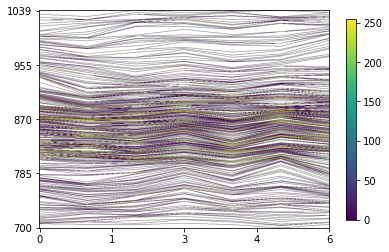

In [189]:
print(int(np.round((300-1)*0.4)))

fig, ax = plt.subplots()
plot_line_density(pd.DataFrame(fcst_entry._sorted_samples).transpose(), ax)

In [158]:
Forecast??

In [152]:
quantile(self=fcst_entry, q=0.8)

array([919.8759 , 905.3271 , 911.1023 , 912.5108 , 907.48175, 916.1337 ,
       910.03845], dtype=float32)

In [148]:
fcst_entry.quantile??

<AxesSubplot:>

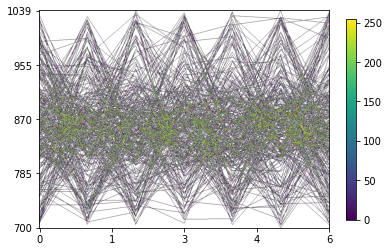

In [147]:
import datashader as ds
import datashader.transfer_functions as tfnc


# canvas settings
w = 1000
h = 750
dpi = 150


def plot_line_density(df, ax):
    # Each column is one data sample
    idx = df.index # keep index to format plot in later stage
    df = df.reset_index(drop=True)

    # Append row with nan-values (makes it apparently much faster)
    df = df.append(pd.DataFrame([np.array([np.nan] * len(df.columns))], columns=df.columns, index=[np.nan]))

    # Reshape
    x, y = df.shape
    arr = df.values.reshape((x * y, 1), order='F')
    df_reshaped = pd.DataFrame(arr, columns=list('y'), index=np.tile(df.index.values, y))
    df_reshaped = df_reshaped.reset_index()
    df_reshaped.columns.values[0] = 'x'

    # Create canvas
    x_range = (min(df.index.values), max(df.index.values))
    y_range = (df.min().min(), df.max().max())
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)

    # Aggregate to heatmap
    aggs = cvs.line(df_reshaped, 'x', 'y', ds.count())
    heatmap_img = tfnc.Image(tfnc.shade(aggs, cmap=plt.cm.viridis))

    # plot
    im = ax.imshow(heatmap_img.to_pil())
    cbar = fig.colorbar(im, fraction=0.03, pad=0.05) #TODO: not pixel value but count of time series
    
    # re-format axes
    ax.set_xticks(np.linspace(0, w, 5))
    ax.set_yticks(np.linspace(h, 0, 5))
    ax.set_xticklabels(np.linspace(idx[0], idx[-1], 5).astype(int))
    ax.set_yticklabels(np.linspace(np.nanmin(df.values), np.nanmax(df.values), 5).astype(int))
    return ax


fig, ax = plt.subplots()    
plot_line_density(pd.DataFrame(fcst_entry.samples).transpose(), ax)

In [126]:
vals = list()
for c in np.linspace(0, 1, 20):
#     print(fcst_entry.quantile(c))
    vals.append(coverage(target, fcst_entry.quantile(c)))

<AxesSubplot:>

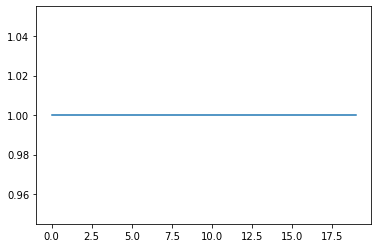

In [127]:
pd.Series(vals).plot()

In [108]:
coverage(target, fcst_entry.quantile(0.7))

0.8571428571428571

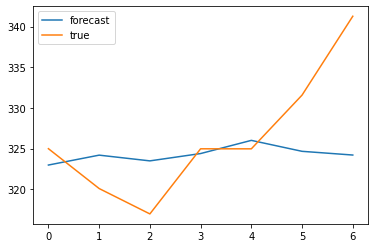

In [96]:
plt.plot(fcst_entry.quantile(0.4), label='forecast')
plt.plot(target, label='true')
plt.legend()

In [91]:
((target <= fcst_entry.quantile(0.4)) - 0.4) * (fcst_entry.quantile(0.4) - target)

array([0.80491943, 2.46452637, 3.91563721, 0.23375244, 0.62442627,
       2.76729736, 6.83048096])

In [83]:
target = extract_pred_target(ts_entry, fcst_entry)

quantile_loss(target, fcst_entry.quantile(0.4), 0.4)

35.282080078125

In [72]:
r = list()
for i in np.linspace(0, 1, 400):
    r.append(ts_entry.quantile(i).values)

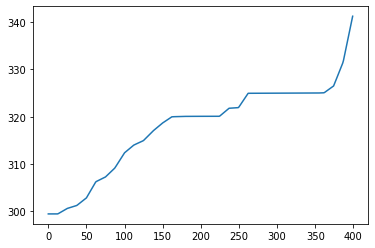

In [73]:
plt.plot(r)

In [ ]:
quantile_loss()

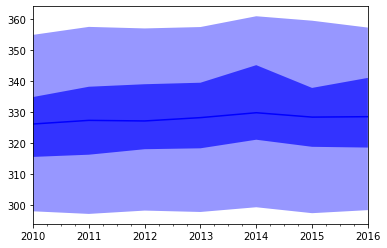

In [53]:
test.plot()

In [52]:
test.quantile(0.8)

array([338.94562, 343.13583, 343.12585, 343.55182, 347.85352, 343.71814,
       345.09146], dtype=float32)

In [33]:
for prediction_length in np.arange(7, 8):
    metadata['prediction_length'] = prediction_length
    train_ds, test_ds = get_gluon_ds()
    test_ds = ListDataset(test_ds.list_data[:200], freq=metadata['freq'])
    metrics_tf_z = train_eval_loop()

  0%|          | 0/200 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 200/200 [00:02<00:00, 80.27it/s]


{'MSE': 1.9180582593594278, 'abs_error': 1763.81005692482, 'abs_target_sum': 1691.5154285430908, 'abs_target_mean': 1.208225306102208, 'seasonal_error': 0.6620087969303131, 'MASE': 2.402782361510859, 'MAPE': 1.3583937737633385, 'sMAPE': 1.7857736520552867, 'OWA': nan, 'MSIS': 44.91538484120101, 'QuantileLoss[0.1]': 570.1236696004868, 'Coverage[0.1]': 0.05857142857142858, 'QuantileLoss[0.2]': 976.387606856227, 'Coverage[0.2]': 0.06428571428571428, 'QuantileLoss[0.3]': 1307.7273443125187, 'Coverage[0.3]': 0.0757142857142857, 'QuantileLoss[0.4]': 1570.1502625584603, 'Coverage[0.4]': 0.09285714285714285, 'QuantileLoss[0.5]': 1763.8100714869797, 'Coverage[0.5]': 0.10785714285714285, 'QuantileLoss[0.6]': 1900.7557868711651, 'Coverage[0.6]': 0.12714285714285714, 'QuantileLoss[0.7]': 1947.264079684764, 'Coverage[0.7]': 0.15428571428571428, 'QuantileLoss[0.8]': 1894.5944213688372, 'Coverage[0.8]': 0.20357142857142857, 'QuantileLoss[0.9]': 1675.3524019807578, 'Coverage[0.9]': 0.2714285714285714,

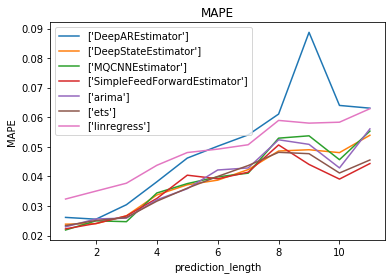

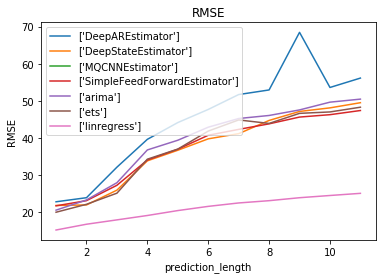

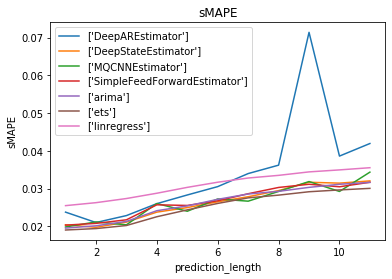

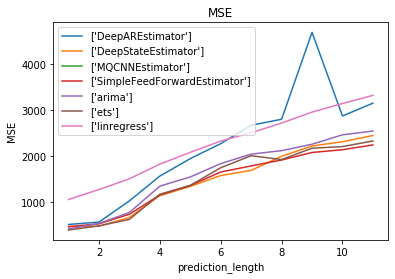

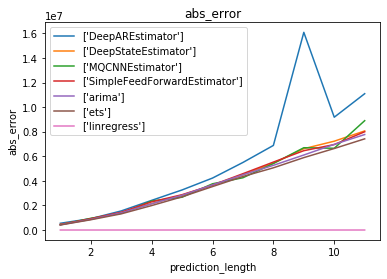

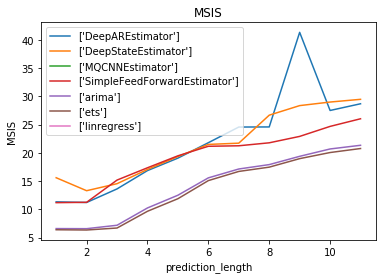

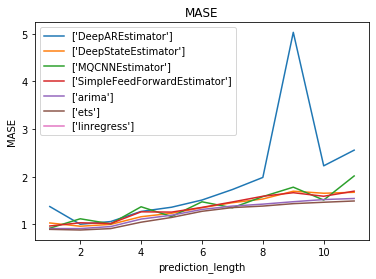

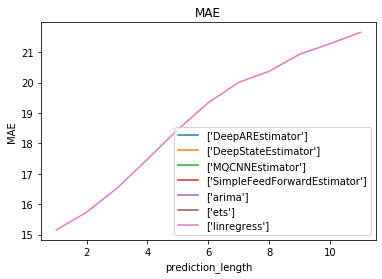

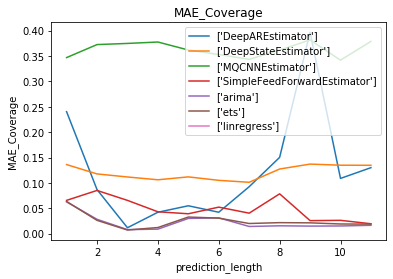

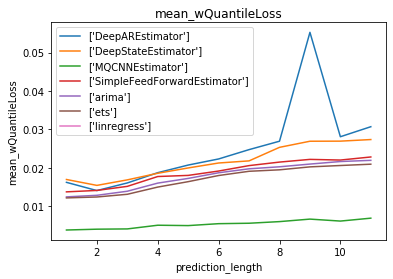

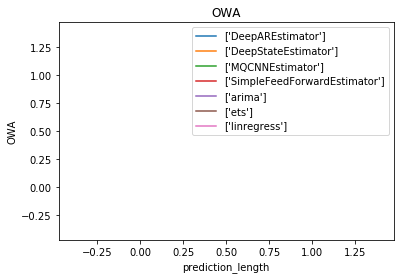

In [50]:
fpath = os.path.join(data_dir, 'sensitivity-metrics.csv')
metrics = pd.read_csv(fpath)

metrics.loc[metrics['method_name']=="ets", 'predictor'] = "ets"
metrics.loc[metrics['method_name']=="arima", 'predictor'] = "arima"


def plot_metrics(ax, metric):
    for gr, df in metrics.groupby('predictor'):
        ax.plot(df['prediction_length'], df[metric], label=df['predictor'].unique())
        ax.set_ylabel(f'{metric}')
        ax.set_xlabel('prediction_length')
    ax.legend()
    return ax


for metric in ['MAPE', 'RMSE', 'sMAPE', 'MSE', 'abs_error', 'MSIS', 'MASE',
               'MAE', 'MAE_Coverage', 'mean_wQuantileLoss', 'OWA']:
    fig, ax = plt.subplots()
    plot_metrics(ax, metric=metric)
    ax.set_title(metric)

In [47]:
metrics.columns

Index(['add_trend', 'cardinality', 'cell_type', 'dropout_rate', 'dtype',
       'embedding_dimension', 'freq', 'innovation_bounds', 'issm', 'lead_time',
       'noise_std_bounds', 'num_cells', 'num_layers', 'num_parallel_samples',
       'past_length', 'prediction_length', 'prior_cov_bounds', 'scaling',
       'time_features', 'use_feat_dynamic_real', 'use_feat_static_cat',
       'batch_size', 'clip_gradient', 'ctx', 'epochs', 'halt', 'hybridize',
       'init', 'learning_rate', 'learning_rate_decay_factor',
       'minimum_learning_rate', 'num_batches_per_epoch', 'patience',
       'weight_decay', 'predictor', 'predictor_id', 'MSE', 'abs_error',
       'abs_target_sum', 'abs_target_mean', 'seasonal_error', 'MASE', 'MAPE',
       'sMAPE', 'OWA', 'MSIS', 'QuantileLoss[0.1]', 'Coverage[0.1]',
       'QuantileLoss[0.2]', 'Coverage[0.2]', 'QuantileLoss[0.3]',
       'Coverage[0.3]', 'QuantileLoss[0.4]', 'Coverage[0.4]',
       'QuantileLoss[0.5]', 'Coverage[0.5]', 'QuantileLoss[0.6]',
   

In [17]:
def forecast_transects(transects, dataset, predictor, freq=None, 
                       prediction_length=None, **kwargs):
    
    if prediction_length is None:
        prediction_length = metadata['prediction_length']
        
    if freq is None:
        freq = metadata['freq']

    dataset = ListDataset(
        [
            i for i in iter(dataset) if i['item_id'] in transects
        ], 
        freq=metadata['freq']
    )
    return iter(dataset), predictor.predict(dataset)
     

    
random_selection = np.random.choice(tf.index, size=50)
duck = [f'BOX_160_055_3{i}' for i in np.arange(42, 50, 1)]    

ts_it, forecast_it = forecast_transects(
    transects=random_selection,
    dataset=test_ds,
    predictor=predictor,
)

### Load model

In [18]:
# from gluonts.model.predictor import Predictor
# mpath = os.path.join(model_dir, 'SimpleFeedForwardEstimator-176')
# predictor_deserialized = Predictor.deserialize(Path(mpath))

### Plot predictions

In [19]:
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl

plt.style.use(os.path.join(configuration_dir, 'PaperSingleFig.mplstyle'))

def plot_prob_forecast(ax, ts, fcst):
    
    prediction_intervals = (50.0, 90.0)
    legend = [f"{ts['item_id']}", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    
    idx = pd.date_range(
        start=ts["start"],
        periods=len(ts["target"]),
        freq="AS"
    )
    
    ts = pd.Series(ts["target"], index=idx)
    ts.plot(ax=ax)  # plot the time series
    
    fcst.plot(
        prediction_intervals=prediction_intervals,
        color='g'
    ) 
    
    ax.set_ylabel('Relative shoreline position (m)')
    ax.set_xlabel('Time (yrs)')
    ax.grid(which="both")
    ax.legend(legend, loc="upper left")
    
    return ax


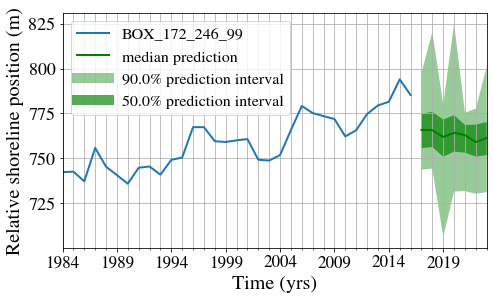

In [43]:
fig, ax = plt.subplots()
plot_prob_forecast(ax, next(ts_it), next(forecast_it))
# plt.savefig(os.path.join(report_dir, 'images/deepar-1.pdf'), dpi=300)
plt.show()

In [21]:
`

SyntaxError: invalid syntax (<ipython-input-21-f6460d7d9d2b>, line 1)